In [1]:
# Step 1: Install the package (only needed once)
!pip install db-dtypes

In [2]:
pip install pandas scikit-learn google-cloud-bigquery xgboost matplotlib seaborn

     -------------------------------------- 124.9/124.9 MB 1.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
from google.cloud import bigquery
import pandas as pd
import numpy as np

# Initialize client
key_path = 'C:/Users/HP/airflow-docker/keys/gcp_key.json'
client = bigquery.Client.from_service_account_json(key_path)

# Query data
query = """
SELECT * FROM `bigquery-email-454109.golden_layer.golden_customer_summary`
"""

df = client.query(query).to_dataframe()

# Add random churn if not already present
df['churn'] = np.random.randint(0, 2, size=len(df))

print("Data loaded successfully.")
df.head()

c:\Users\HP\Anaconda3\lib\site-packages\google\cloud\bigquery\table.py:2551: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\HP\Anaconda3\lib\site-packages\google\cloud\bigquery\table.py:2565: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\HP\Anaconda3\lib\site-packages\google\cloud\bigquery\table.py:2579: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\HP\Anaconda3\lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endp

Data loaded successfully.


,customer_id,first_name,last_name,age,gender,country,signup_date,products_bought,time_spent,no_of_tickets_raised,resolution_time,churn
0,362,Bob,Wilson,31,Female,UK,2021-10-18,2,97.13,1,20.0,1
1,3586,John,Davis,42,Male,UK,2020-12-10,2,87.77,1,20.0,1
2,3935,Jane,Doe,57,Female,UK,2022-08-19,2,57.89,1,20.0,0
3,4586,Bob,Miller,51,Male,USA,2021-02-02,2,45.06,1,20.0,1
4,3595,Emily,Wilson,56,Female,USA,2022-07-19,2,91.79,1,22.0,1


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

# Separate features and target
X = df.drop('churn', axis=1)
y = df['churn']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['number']).columns

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Full pipeline with classifier
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [5]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model.fit(X_train, y_train)

print("Model trained successfully.")

Model trained successfully.


Accuracy: 50.90%

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.55      0.54       520
           1       0.49      0.47      0.48       480

    accuracy                           0.51      1000
   macro avg       0.51      0.51      0.51      1000
weighted avg       0.51      0.51      0.51      1000



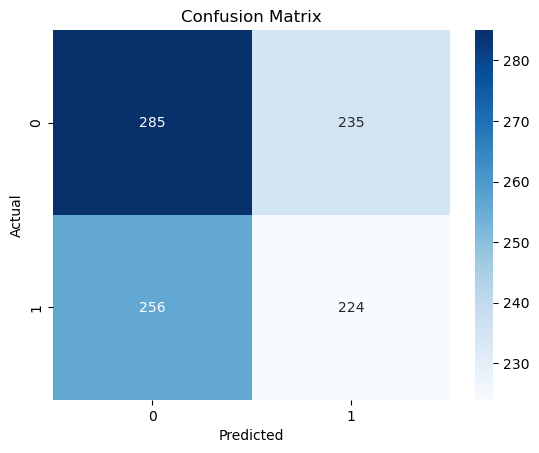

In [6]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict
y_pred = model.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2%}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [7]:
from xgboost import XGBClassifier

model.set_params(classifier=XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
model.fit(X_train, y_train)

# Re-evaluate
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")

c:\Users\HP\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [22:55:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 49.30%


In [8]:
import joblib

joblib.dump(model, "churn_model.pkl")
print("Model saved to churn_model.pkl")

Model saved to churn_model.pkl


In [9]:
# Add predictions to test DataFrame
X_test['predicted_churn'] = y_pred

# Upload back to BigQuery
from google.cloud import bigquery

job_config = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")
table_id = "bigquery-email-454109.golden_layer.churn_predictions"

job = client.load_table_from_dataframe(X_test, table_id, job_config=job_config)
job.result()

print(f"Uploaded {len(X_test)} predictions to {table_id}")

c:\Users\HP\Anaconda3\lib\site-packages\google\cloud\bigquery\_pandas_helpers.py:489: FutureWarning: Loading pandas DataFrame into BigQuery will require pandas-gbq package version 0.26.1 or greater in the future. Tried to import pandas-gbq and got: No module named 'pandas_gbq'
  warnings.warn(


Uploaded 1000 predictions to bigquery-email-454109.golden_layer.churn_predictions
